<a href="https://colab.research.google.com/github/EitherCod/protein2mRNA/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import skimage as sk
import pandas as pd 
import skimage.io as skio
import imageio
import cv2
from torch.utils.data import Dataset
import torch.nn as nn
from torch.utils.data import DataLoader
import random
import tqdm.notebook
import pandas as pd
from sklearn.metrics import confusion_matrix

In [ ]:
data_file = "dataset.txt"
bases = ['A', 'C', 'G', 'T']
amino_acids = ['A', 'C', 'D','E','F','G','H','I','K','L','M',
 'N','P','Q','R','S','T','V','W','Y', '*']

In [ ]:
#Codon Nuemeric Representation
def codon_encoding():
    encoding = {}
    count = 0
    for base_one in bases:
        for base_two in bases:
            for base_three in bases:
                encoding[base_one + base_two + base_three] = count 
                count +=1
    return encoding 

In [ ]:
#Get all Codons
def all_codons():
  codons = []
  for base_one in bases:
    for base_two in bases:
      for base_three in bases:
        codons.append(base_one + base_two + base_three)
  codons.append("PAD")
  return codons 

In [ ]:
#Amino Acid Nuemeric Representation
def amino_acid_encoding():
    encoding = {}
    count = 0
    for acid in amino_acids:
        encoding[acid] = count
        count += 1
    return encoding

In [ ]:
codon_dict = codon_encoding()
acid_dict = amino_acid_encoding()

In [ ]:
def encode_codon_sequence(codon_dict, sequence):
    encoded = []
    num_codons = int(len(sequence) / 3) 
    for i in range(num_codons):
        encode = codon_dict[sequence[3*i:3*i +3]]
        encoded.append(encode)
    return encoded

In [ ]:
def encode_acid_sequence(acid_dict, sequence):
    return [acid_dict[acid] for acid in sequence if acid not in ['\n']]

In [ ]:
def read_data(file_name):
    codon_sequences = []
    acid_sequences = []
    data = open(file_name)
    
    for row in data:
        row = row.split(' ')
        cur_codon = encode_codon_sequence(codon_dict, row[1])
        cur_acid = encode_acid_sequence(acid_dict, row[2])
        
        codon_sequences.append(cur_codon)
        acid_sequences.append(cur_acid)
        
    return codon_sequences, acid_sequences

In [ ]:
def shuffle_data(codon_sequences, acid_sequences):
    temp = list(zip(codon_sequences, acid_sequences))
    random.shuffle(temp)
    codon_sequences, acid_sequences = zip(*temp)
    
    return codon_sequences, acid_sequences

In [ ]:
encoded_sequences, encoded_acids = read_data(data_file)
encoded_sequences, encoded_acids = shuffle_data(encoded_sequences, encoded_acids)

train_end = int(0.8 * len(encoded_sequences))
val_end = int(0.9 * len(encoded_sequences))

#Split Data
train_sequences, train_acids = encoded_sequences[:train_end], encoded_acids[:train_end]
val_sequences, val_acids = encoded_sequences[train_end:val_end], encoded_acids[train_end:val_end]
test_sequences, test_acids = encoded_sequences[val_end:], encoded_acids[val_end:]

In [ ]:
PAD_ID_CODON = 64 
PAD_ID_ACID = 21
NUM_ACIDS = 22
NUM_CODONS = 65

class ecoliDataSet(torch.utils.data.Dataset):
    def __init__(self, codon_sequences, acid_sequences):
        self.codon_sequences = codon_sequences
        self.acid_sequences = acid_sequences

    def __len__(self):
        return len(self.codon_sequences)

    def __getitem__(self, index):
        codon_seq = self.codon_sequences[index]
        acid_seq = self.acid_sequences[index]
        return torch.tensor(codon_seq, dtype= torch.int64), torch.tensor(acid_seq, dtype=torch.int64)

    @staticmethod
    def collate(batch):
        codon_seq_list = [codon_seq for (codon_seq, _) in batch]
        acid_seq_list = [acid_seq for (_, acid_seq) in batch]

        codon_seq_batch = nn.utils.rnn.pad_sequence(codon_seq_list, batch_first=False, padding_value=PAD_ID_CODON)
        acid_seq_batch = nn.utils.rnn.pad_sequence(acid_seq_list, batch_first=False, padding_value=PAD_ID_ACID)

        codon_seq_lengths = [len(seq) for seq in codon_seq_list]
        codon_seq_lengths = torch.tensor(codon_seq_lengths, dtype=torch.int64)
        
        acid_seq_lengths = [len(seq) for seq in acid_seq_list]
        acid_seq_lengths = torch.tensor(acid_seq_lengths, dtype=torch.int64)


        return codon_seq_batch, acid_seq_batch, codon_seq_lengths, acid_seq_lengths

In [ ]:
#Data Sets
training_set = ecoliDataSet(train_sequences, train_acids)
val_set = ecoliDataSet(val_sequences, val_acids)
test_set = ecoliDataSet(test_sequences, test_acids)

#Data Loaders
train_dataloader = torch.utils.data.DataLoader(
    training_set, batch_size=32, shuffle=True, collate_fn=ecoliDataSet.collate)
val_dataloader = torch.utils.data.DataLoader(
    val_set, batch_size=32, shuffle=False, collate_fn=ecoliDataSet.collate)
test_dataloader = torch.utils.data.DataLoader(
    test_set, batch_size=32, shuffle=False, collate_fn=ecoliDataSet.collate)

In [ ]:
class LSTM(nn.Module):
    def __init__(self,  hidden_size, layers):
        super().__init__()

        
        self.embedding = nn.Embedding(22, 32, padding_idx=PAD_ID_ACID)
        self.hidden_size = hidden_size
        self.num_layers = layers

        self.lstm = nn.LSTM(input_size=32,
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers, 
                            batch_first=False, 
                            bidirectional = True)

        self.linear = nn.Linear(self.hidden_size * 2, NUM_CODONS)

        self.loss = torch.nn.CrossEntropyLoss(reduction = "mean")

    def forward(self, X, lengths):
        X = self.embedding(X)
        X = X.float()
        #X = nn.utils.rnn.pack_padded_sequence(X, batch_first= False, lengths = lengths.to("cpu"), enforce_sorted=False)
        output, _ = self.lstm(X, None)
        #Move Batch To The First Dimension
        output = output.permute((1,0, 2))
        output = self.linear(output)
        
        #Flatten Batch and Sequence Dimension
        output = output.flatten(0,1)
        return output

    def compute_loss(self, X, codon_seq, lengths):
        Y_true = codon_seq.permute((1,0)).flatten()
        predicted = self.forward(X, lengths)
        return self.loss(predicted, Y_true)

In [ ]:
class RNN(nn.Module):
    def __init__(self, hidden_size, layers):
        super().__init__()

        
        self.embedding = nn.Embedding(22, 32, padding_idx=PAD_ID_ACID)
        self.hidden_size = hidden_size
        self.num_layers = layers

        self.rnn = nn.RNN(input_size=32,
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers, 
                            batch_first=False, 
                            bidirectional = True)

        self.linear = nn.Linear(self.hidden_size * 2, NUM_CODONS)

        self.loss = torch.nn.CrossEntropyLoss(reduction = "mean")

    def forward(self, X, lengths):
        X = self.embedding(X)
        X = X.float()
        #X = nn.utils.rnn.pack_padded_sequence(X, batch_first= False, lengths = lengths.to("cpu"), enforce_sorted=False)
        output, _ = self.rnn(X, None)
        #Move Batch To The First Dimension
        output = output.permute((1,0, 2))
        output = self.linear(output)
        
        #Flatten Batch and Sequence Dimension
        output = output.flatten(0,1)
        return output

    def compute_loss(self, X, codon_seq, lengths):
        Y_true = codon_seq.permute((1,0)).flatten()
        predicted = self.forward(X, lengths)
        return self.loss(predicted, Y_true)

In [ ]:
class GRU(nn.Module):
    def __init__(self, hidden_size, layers):
        super().__init__()

        
        self.embedding = nn.Embedding(22, 32, padding_idx=PAD_ID_ACID)
        self.hidden_size = hidden_size
        self.num_layers = layers

        self.gru = nn.GRU(input_size=32,
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers, 
                            batch_first=False, 
                            bidirectional = True)

        self.linear = nn.Linear(self.hidden_size * 2, NUM_CODONS)

        self.loss = torch.nn.CrossEntropyLoss(reduction = "mean")

    def forward(self, X, lengths):
        X = self.embedding(X)
        X = X.float()
        #X = nn.utils.rnn.pack_padded_sequence(X, batch_first= False, lengths = lengths.to("cpu"), enforce_sorted=False)
        output, _ = self.gru(X, None)
        #Move Batch To The First Dimension
        output = output.permute((1,0, 2))
        output = self.linear(output)
        
        #Flatten Batch and Sequence Dimension
        output = output.flatten(0,1)
        return output

    def compute_loss(self, X, codon_seq, lengths):
        Y_true = codon_seq.permute((1,0)).flatten()
        predicted = self.forward(X, lengths)
        return self.loss(predicted, Y_true)


In [ ]:
def train(network, train_data, val_data, num_epochs, lr, decay, model_file):
    train_loss = []
    val_loss = []

    optimizer = torch.optim.Adam(
     network.parameters(),
     lr=lr,
     betas=(0.9, 0.98),
     eps=1e-9,
     weight_decay=decay
    )

    # Create the scheduler that will vary the learning rate
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
     optimizer,
     lr,
     epochs=num_epochs,
     steps_per_epoch=len(train_dataloader),
     pct_start=0.02  # warm up for 2% of the total training time
    )
    
    network = network.cuda()
    
    best_val_accuracy = 0.0
    for epoch in tqdm.notebook.trange(num_epochs, desc="training", unit="epoch"):
        with tqdm.notebook.tqdm(train_data, desc="epoch {}".format(epoch + 1),
                            unit="batch", total=len(train_data)) as batch_iterator:
            network.train()
            total_loss = 0.0
            for i, (codon_seq_batch, acid_seq_batch, codon_seq_lengths, acid_seq_lengths) in enumerate(batch_iterator, start=1):
                acid_seq_batch = acid_seq_batch.cuda()
                acid_seq_lengths = acid_seq_lengths.cuda()
                codon_seq_batch = codon_seq_batch.cuda()
                
                optimizer.zero_grad() # zero out all old gradients
                loss = network.compute_loss(acid_seq_batch, codon_seq_batch, acid_seq_lengths)
                total_loss += loss.item()
                loss.backward() # compute gradients
                optimizer.step() # backpropagate
                scheduler.step()
                
            val_accuracy, loss = evaluate(network, val_dataloader)
            batch_iterator.set_postfix(mean_loss=total_loss / i, val_accuracy=val_accuracy)
            train_loss.append(total_loss / i)
            val_loss.append(loss)
                
            if val_accuracy > best_val_accuracy:
                print("Obtained a new best validation accuracy of {:.3f}, saving model checkpoint to {}".
                      format(val_accuracy, model_file))
                if model_file != None:
                  torch.save(network.state_dict(), model_file)
                best_val_accuracy = val_accuracy
    if model_file != None:               
      network.load_state_dict(torch.load(model_file))

    return train_loss, val_loss
    
def evaluate(network, dataloader):
    total_loss = 0
    total_batches = 0
    network = network.cuda()
    correct, total = 0, 0
    with torch.no_grad():
        for (codon_seq_batch, acid_seq_batch, codon_seq_lengths, acid_seq_lengths) in dataloader:
            acid_seq_batch = acid_seq_batch.cuda()
            acid_seq_lengths = acid_seq_lengths.cuda()
            codon_seq_batch = codon_seq_batch.cuda()

            loss = network.compute_loss(acid_seq_batch, codon_seq_batch, acid_seq_lengths).item()
            total_loss += loss
            total_batches += 1

            codon_seq_batch =  codon_seq_batch.permute((1,0)).flatten()
            max_len = codon_seq_lengths.max()
            num_padding = (max_len - codon_seq_lengths).sum()
            codon_pred = network(acid_seq_batch, acid_seq_lengths).argmax(-1)
            correct += (codon_pred == codon_seq_batch).sum().item()
            total += len(codon_pred)

            correct_padding = torch.bitwise_and(codon_pred == 64, codon_seq_batch == 64).sum()

            correct -= correct_padding
            total -= num_padding    

    return correct / total, total_loss / total_batches

def get_predictions(network, dataloader):
    network = network.cuda()
    correct, total = 0, 0
    predictions = []
    labels = []
    with torch.no_grad():
        for (codon_seq_batch, acid_seq_batch, codon_seq_lengths, acid_seq_lengths) in dataloader:
            codon_seq_batch =  codon_seq_batch.permute((1,0)).flatten()
            acid_seq_batch = acid_seq_batch.cuda()
            acid_seq_lengths = acid_seq_lengths.cuda()
            codon_seq_batch = codon_seq_batch.cuda()

            max_len = codon_seq_lengths.max()
            num_padding = (max_len - codon_seq_lengths).sum()

            codon_pred = network(acid_seq_batch, acid_seq_lengths).argmax(-1)
            
            predictions.extend(codon_pred.cpu().tolist())
            labels.extend(codon_seq_batch.cpu().tolist())

             

    return labels, predictions
                            

In [ ]:
#Testing Different Hidden Size, Number of Layers, Learning Rate
def hyper_parameter_search(type_of_search, type_of_model):
  #Type of Search Learning Rate, Hidden Size, Layers
  all_train_loss = []
  all_val_loss = []
  learning_rates = [1e-2, 1e-3, 1e-4]
  decay_rates = [1e-3, 1e-4, 1e-5]
  hidden_sizes = [64, 96, 128]
  layers = [3,4,5]

  if type_of_search == 'Layers':
    for layer in layers:
      model = type_of_model(64, layer)
      train_loss, val_loss = train(model, train_dataloader, val_dataloader, 5, 1e-3, 1e-4, None)
      print("Minimum Train Loss With Layer Size {}: {}".format(layer, min(train_loss)))
      print("Minimum Validation Loss With Layer Size {}: {}".format(layer, min(val_loss)))
      all_train_loss.append(train_loss)
      all_val_loss.append(val_loss)
  
  if type_of_search == 'Hidden Size':
    for hidden_size in hidden_sizes:
      model = type_of_model(hidden_size, 4)
      train_loss, val_loss = train(model, train_dataloader, val_dataloader, 5, 1e-3, 1e-4, None)
      print("Minimum Train Loss With Hidden Size {}: {}".format(hidden_size, min(train_loss)))
      print("Minimum Validation Loss With Hidden Size {}: {}".format(hidden_size, min(val_loss)))
      all_train_loss.append(train_loss)
      all_val_loss.append(val_loss)
    
  
  if type_of_search == 'Learning Rate':
    for i in range(3):
      model = type_of_model(64, 4)
      train_loss, val_loss = train(model, train_dataloader, val_dataloader, 5, learning_rates[i], decay_rates[i], None)
      print("Minimum Train Loss With Learning Rate {}: {}".format(learning_rates[i], min(train_loss)))
      print("Minimum Validation Loss With Learning Rate {}: {}".format(learning_rates[i], min(val_loss)))
      all_train_loss.append(train_loss)
      all_val_loss.append(val_loss)

  return all_train_loss, all_val_loss


In [ ]:
#RNN Hyper Parameter Search Layers
train_loss_rnn_layer_search , val_loss_rnn_layer_search = hyper_parameter_search("Layers", RNN)

In [ ]:
#RNN Hyper Parameter Search Hidden Size
train_loss_rnn_hidden_search , val_loss_rnn_hidden_search = hyper_parameter_search('Hidden Size', RNN)

In [ ]:
#RNN Hyper Parameter Search Learning Rate
train_loss_rnn_learning_search , val_loss_rnn_learning_search = hyper_parameter_search('Learning Rate', RNN)

In [ ]:
#LSTM Hyper Parameter Search Layers
train_loss_lstm_layer_search , val_loss_lstm_layer_search = hyper_parameter_search("Layers", LSTM)


In [ ]:
#LSTM Hyper Parameter Search  Hidden Size
train_loss_hidden_learning_search , val_loss_lstm_hidden_search = hyper_parameter_search('Hidden Size', LSTM)

In [ ]:
#LSTM Hyper Parameter Learning Rate
train_loss_lstm_learning_search , val_loss_lstm_learning_search = hyper_parameter_search('Learning Rate', LSTM)

In [ ]:
# GRU hyper parameter search layers
train_loss_gru_layer_search, val_loss_gru_layer_search = hyper_parameter_search("Layers", GRU)

In [ ]:
# GRU hyper parameter search hidden size
train_loss_gru_hidden_search, val_loss_gru_hidden_search = hyper_parameter_search('Hidden Size', GRU)

In [ ]:
# GRU hyper parameter search learning rate
train_loss_gru_learning_search, val_loss_gru_learning_search = hyper_parameter_search('Learning Rate', GRU)

In [ ]:
rnn = RNN(128, 5)
lstm = LSTM(96, 3)
gru = GRU(96, 4)

In [ ]:
train_loss, val_loss = train(rnn, train_dataloader, val_dataloader, 20, 1e-3, 1e-4, "rnn.pt")

training:   0%|          | 0/20 [00:00<?, ?epoch/s]

epoch 1:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.517, saving model checkpoint to rnn.pt


epoch 2:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.540, saving model checkpoint to rnn.pt


epoch 3:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.547, saving model checkpoint to rnn.pt


epoch 4:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.548, saving model checkpoint to rnn.pt


epoch 5:   0%|          | 0/98 [00:00<?, ?batch/s]

epoch 6:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.551, saving model checkpoint to rnn.pt


epoch 7:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.552, saving model checkpoint to rnn.pt


epoch 8:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.552, saving model checkpoint to rnn.pt


epoch 9:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.554, saving model checkpoint to rnn.pt


epoch 10:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.555, saving model checkpoint to rnn.pt


epoch 11:   0%|          | 0/98 [00:00<?, ?batch/s]

epoch 12:   0%|          | 0/98 [00:00<?, ?batch/s]

epoch 13:   0%|          | 0/98 [00:00<?, ?batch/s]

epoch 14:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.555, saving model checkpoint to rnn.pt


epoch 15:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.556, saving model checkpoint to rnn.pt


epoch 16:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.556, saving model checkpoint to rnn.pt


epoch 17:   0%|          | 0/98 [00:00<?, ?batch/s]

epoch 18:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.557, saving model checkpoint to rnn.pt


epoch 19:   0%|          | 0/98 [00:00<?, ?batch/s]

epoch 20:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.558, saving model checkpoint to rnn.pt


Text(0.5, 1.0, 'Training Loss and Validation Loss over Iterations For RNN Model')

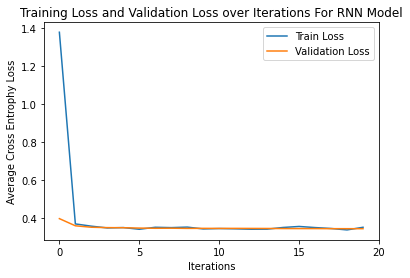

In [ ]:
plt.plot(list(range(0,20)), train_loss, label = "Train Loss")
plt.plot(list(range(0,20)), val_loss, label ="Validation Loss")
plt.xticks([0,5,10,15,20])
plt.xlabel("Iterations")
plt.ylabel("Average Cross Entrophy Loss")
plt.legend(loc="upper right")
plt.title("Training Loss and Validation Loss over Iterations For RNN Model")

In [ ]:
train_loss, val_loss = train(lstm, train_dataloader, val_dataloader, 20, 1e-3, 1e-4, "lstm.pt")

training:   0%|          | 0/20 [00:00<?, ?epoch/s]

epoch 1:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.052, saving model checkpoint to lstm.pt


epoch 2:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.510, saving model checkpoint to lstm.pt


epoch 3:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.534, saving model checkpoint to lstm.pt


epoch 4:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.537, saving model checkpoint to lstm.pt


epoch 5:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.546, saving model checkpoint to lstm.pt


epoch 6:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.548, saving model checkpoint to lstm.pt


epoch 7:   0%|          | 0/98 [00:00<?, ?batch/s]

epoch 8:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.550, saving model checkpoint to lstm.pt


epoch 9:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.550, saving model checkpoint to lstm.pt


epoch 10:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.553, saving model checkpoint to lstm.pt


epoch 11:   0%|          | 0/98 [00:00<?, ?batch/s]

epoch 12:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.555, saving model checkpoint to lstm.pt


epoch 13:   0%|          | 0/98 [00:00<?, ?batch/s]

epoch 14:   0%|          | 0/98 [00:00<?, ?batch/s]

epoch 15:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.555, saving model checkpoint to lstm.pt


epoch 16:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.556, saving model checkpoint to lstm.pt


epoch 17:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.557, saving model checkpoint to lstm.pt


epoch 18:   0%|          | 0/98 [00:00<?, ?batch/s]

epoch 19:   0%|          | 0/98 [00:00<?, ?batch/s]

epoch 20:   0%|          | 0/98 [00:00<?, ?batch/s]

Text(0.5, 1.0, 'Training Loss and Validation Loss over Iterations For LSTM Model')

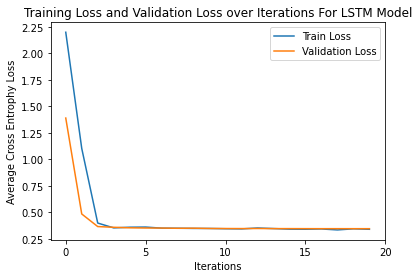

In [ ]:
plt.plot(list(range(0,20)), train_loss, label = "Train Loss")
plt.plot(list(range(0,20)), val_loss, label ="Validation Loss")
plt.xticks([0,5,10,15,20])
plt.xlabel("Iterations")
plt.ylabel("Average Cross Entrophy Loss")
plt.legend(loc="upper right")
plt.title("Training Loss and Validation Loss over Iterations For LSTM Model")

In [ ]:
train_loss, val_loss = train(gru, train_dataloader, val_dataloader, 20, 1e-3, 1e-4, "gru.pt")

training:   0%|          | 0/20 [00:00<?, ?epoch/s]

epoch 1:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.493, saving model checkpoint to gru.pt


epoch 2:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.533, saving model checkpoint to gru.pt


epoch 3:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.541, saving model checkpoint to gru.pt


epoch 4:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.544, saving model checkpoint to gru.pt


epoch 5:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.547, saving model checkpoint to gru.pt


epoch 6:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.549, saving model checkpoint to gru.pt


epoch 7:   0%|          | 0/98 [00:00<?, ?batch/s]

epoch 8:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.551, saving model checkpoint to gru.pt


epoch 9:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.552, saving model checkpoint to gru.pt


epoch 10:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.552, saving model checkpoint to gru.pt


epoch 11:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.554, saving model checkpoint to gru.pt


epoch 12:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.554, saving model checkpoint to gru.pt


epoch 13:   0%|          | 0/98 [00:00<?, ?batch/s]

epoch 14:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.556, saving model checkpoint to gru.pt


epoch 15:   0%|          | 0/98 [00:00<?, ?batch/s]

epoch 16:   0%|          | 0/98 [00:00<?, ?batch/s]

epoch 17:   0%|          | 0/98 [00:00<?, ?batch/s]

epoch 18:   0%|          | 0/98 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.556, saving model checkpoint to gru.pt


epoch 19:   0%|          | 0/98 [00:00<?, ?batch/s]

epoch 20:   0%|          | 0/98 [00:00<?, ?batch/s]

Text(0.5, 1.0, 'Training Loss and Validation Loss over Iterations For GRU Model')

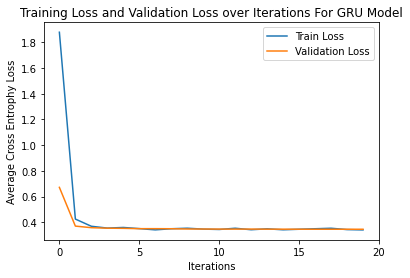

In [ ]:
plt.plot(list(range(0,20)), train_loss, label = "Train Loss")
plt.plot(list(range(0,20)), val_loss, label ="Validation Loss")
plt.xticks([0,5,10,15,20])
plt.xlabel("Iterations")
plt.ylabel("Average Cross Entrophy Loss")
plt.legend(loc="upper right")
plt.title("Training Loss and Validation Loss over Iterations For GRU Model")

In [ ]:
rnn.load_state_dict(torch.load("rnn.pt", map_location=torch.device('cpu')))
accuracy, loss = evaluate(rnn, test_dataloader)
print("RNN Test Accuracy {}, RNN Test Loss {}".format(accuracy, loss))

RNN Test Accuracy 0.5612291097640991, RNN Test Loss 0.30351055012299466


In [ ]:
lstm.load_state_dict(torch.load("lstm.pt", map_location=torch.device('cpu')))
accuracy, loss = evaluate(lstm, test_dataloader)
print("LSTM Test Accuracy {}, LSTM Test Loss {}".format(accuracy, loss))

LSTM Test Accuracy 0.562267541885376, LSTM Test Loss 0.303361523609895


In [ ]:
gru.load_state_dict(torch.load("gru.pt", map_location=torch.device('cpu')))
accuracy, loss = evaluate(gru, test_dataloader)
print("GRU Test Accuracy {}, GRU Test Loss {}".format(accuracy, loss))

GRU Test Accuracy 0.5616235733032227, GRU Test Loss 0.3035392921704512


In [ ]:
def create_confusion_matrix(labels, predictions):
  label_codon = []
  predict_codon = []

  index_to_codon = dict((v, k) for k, v in codon_dict.items())
  index_to_codon[64] = 'PAD'

  for i in labels:
    label_codon.append(index_to_codon[i])

  for i in predictions:
    predict_codon.append(index_to_codon[i])

  CLASSES = all_codons()

  cf_matrix = confusion_matrix(label_codon, predict_codon)
  df_cm = pd.DataFrame(cf_matrix, index = CLASSES,columns = CLASSES)

  return df_cm

In [ ]:
def show_full_df():
  pd.set_option('display.max_rows', None)
  pd.set_option('display.max_columns', None)
  pd.set_option('display.width', None)
  pd.set_option('display.max_colwidth', -1)


In [ ]:
confusion_matrix = create_confusion_matrix(labels, predictions)
show_full_df()

In [ ]:
#Predicted On Y Axis and Actual On X Axis 
confusion_matrix